In [1]:
!pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2 scipy==1.11.4 joblib==1.3.2 threadpoolctl==3.4.0 imbalanced-learn==0.12.3 matplotlib==3.8.4 seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 81.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 41.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalle

In [2]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Standard libraries imported successfully")

Standard libraries imported successfully


In [3]:
# Library imports for SVM workflow
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
import joblib

print(f"\n{'='*60}")
print("ENVIRONMENT SETUP COMPLETE")
print(f"{'='*60}")
print("Execution device: CPU")
print(f"{'='*60}")


ENVIRONMENT SETUP COMPLETE
Execution device: CPU


In [4]:
# Data loading function
def load_stroke_data(data_dir='/kaggle/input/stroke-and-heartdisease/data-pre/'):
    """
    Load preprocessed stroke prediction data
    
    Args:
        data_dir (str): Directory containing preprocessed data files
        
    Returns:
        tuple: (X_train, y_train, X_test, y_test, feature_names)
    """
    print("Loading preprocessed stroke data...")
    
    # Load feature names
    try:
        with open(f'{data_dir}feature_names.txt', 'r') as f:
            feature_names = [line.strip() for line in f.readlines()]
        print(f"Loaded {len(feature_names)} feature names")
    except FileNotFoundError:
        print("Feature names file not found, using default names")
        feature_names = None
    
    # Load training data
    train_data = pd.read_csv(f'{data_dir}train_preprocessed.csv')
    X_train = train_data.drop('stroke', axis=1)
    y_train = train_data['stroke']
    
    # Load test data
    test_data = pd.read_csv(f'{data_dir}test_preprocessed.csv')
    X_test = test_data.drop('stroke', axis=1)
    y_test = test_data['stroke']
    
    # Update feature names if not loaded from file
    if feature_names is None:
        feature_names = X_train.columns.tolist()
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, feature_names

# Load the data
X_train, y_train, X_test, y_test, feature_names = load_stroke_data()

Loading preprocessed stroke data...
Loaded 21 feature names
Training data shape: (7778, 21)
Test data shape: (1022, 21)


In [5]:
# Data exploration
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

print(f"\nTraining set:")
print(f"  - Samples: {X_train.shape[0]:,}")
print(f"  - Features: {X_train.shape[1]}")
print(f"  - Stroke cases: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  - Non-stroke cases: {(~y_train.astype(bool)).sum():,} ({(1-y_train.mean())*100:.2f}%)")

print(f"\nTest set:")
print(f"  - Samples: {X_test.shape[0]:,}")
print(f"  - Features: {X_test.shape[1]}")
print(f"  - Stroke cases: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  - Non-stroke cases: {(~y_test.astype(bool)).sum():,} ({(1-y_test.mean())*100:.2f}%)")

print(f"\nFeature names (first 10):")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i+1:2d}. {name}")
if len(feature_names) > 10:
    print(f"  ... and {len(feature_names)-10} more features")


DATA EXPLORATION

Training set:
  - Samples: 7,778
  - Features: 21
  - Stroke cases: 3,889 (50.00%)
  - Non-stroke cases: 3,889 (50.00%)

Test set:
  - Samples: 1,022
  - Features: 21
  - Stroke cases: 50 (4.89%)
  - Non-stroke cases: 972 (95.11%)

Feature names (first 10):
   1. age
   2. avg_glucose_level
   3. bmi
   4. gender_Female
   5. gender_Male
   6. gender_Other
   7. ever_married_No
   8. ever_married_Yes
   9. work_type_Govt_job
  10. work_type_Never_worked
  ... and 11 more features


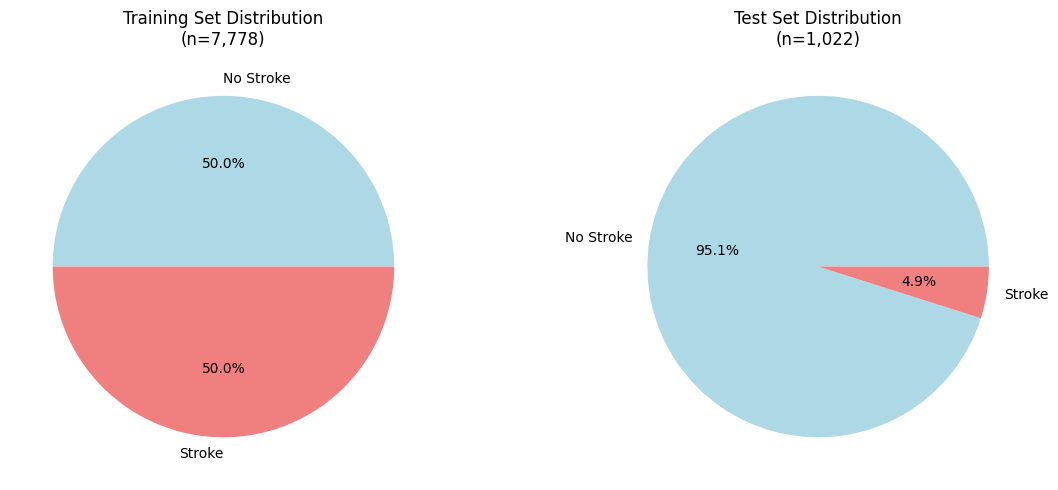


Class imbalance detected - will use balanced class weights in SVM


In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
train_counts = y_train.value_counts()
axes[0].pie(train_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', 
           colors=['lightblue', 'lightcoral'])
axes[0].set_title(f'Training Set Distribution\n(n={len(y_train):,})')

# Test set distribution
test_counts = y_test.value_counts()
axes[1].pie(test_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
           colors=['lightblue', 'lightcoral'])
axes[1].set_title(f'Test Set Distribution\n(n={len(y_test):,})')

plt.tight_layout()
plt.show()

print("\nClass imbalance detected - will use balanced class weights in SVM")

In [7]:
class StrokeSVMModel:
    """Support Vector Machine model for stroke prediction using CPU resources."""
    
    def __init__(self, scoring_metric='recall', decision_threshold=0.5):
        self.model = None
        self.scaler = StandardScaler()
        self.best_params = None
        self.training_time = None
        self.prediction_time = None
        self.scoring_metric = scoring_metric
        self.decision_threshold = decision_threshold
        
        print("Using CPU-based StandardScaler")
        print(f"Grid search scoring metric: {self.scoring_metric}")
        print(f"Default decision threshold: {self.decision_threshold:.2f}")
    
    def set_decision_threshold(self, threshold):
        """Update the decision threshold used for converting probabilities to labels."""
        self.decision_threshold = threshold
        print(f"Decision threshold updated to {self.decision_threshold:.2f}")
    
    def preprocess_data(self, X_train, X_test):
        """Standardize features for SVM training and inference."""
        print("Preprocessing data with standardization...")
        start_time = time.time()
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        preprocessing_time = time.time() - start_time
        print(f"Preprocessing completed in {preprocessing_time:.3f} seconds")
        
        return X_train_scaled, X_test_scaled
    
    def hyperparameter_tuning(self, X_train, y_train, quick_search=False, scoring_metric=None):
        """Perform hyperparameter tuning using GridSearchCV."""
        print("Performing hyperparameter tuning on CPU...")
        
        metric = scoring_metric or self.scoring_metric
        print(f"Using {metric} as the tuning metric")
        
        if quick_search:
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto'],
                'class_weight': ['balanced', {0: 1, 1: 3}]
            }
            print("Using quick search parameter grid")
        else:
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
                'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]
            }
            print("Using comprehensive parameter grid")
        
        svm = SVC(random_state=42, probability=True)
        grid_search = GridSearchCV(svm, param_grid, cv=3, scoring=metric, n_jobs=-1, verbose=1)
        
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time
        
        self.best_params = grid_search.best_params_
        
        print(f"\nHyperparameter tuning completed in {tuning_time:.2f} seconds")
        print(f"Best parameters: {self.best_params}")
        print(f"Best cross-validation {metric}: {grid_search.best_score_:.4f}")
        
        return self.best_params
    
    def train_model(self, X_train, y_train, use_tuning=True, quick_search=False):
        """Train the SVM model with optional hyperparameter tuning."""
        print("\nTraining SVM model on CPU...")
        
        if use_tuning:
            self.hyperparameter_tuning(X_train, y_train, quick_search)
        
        start_time = time.time()
        
        if self.best_params:
            self.model = SVC(**self.best_params, random_state=42, probability=True)
        else:
            self.model = SVC(
                kernel='rbf', C=1.0, gamma='scale', class_weight='balanced',
                random_state=42, probability=True
            )
        
        self.model.fit(X_train, y_train)
        self.training_time = time.time() - start_time
        
        print(f"Model training completed in {self.training_time:.3f} seconds")
    
    def evaluate_model(self, X_test, y_test, threshold=None):
        """Evaluate the trained model on test data."""
        print("\nEvaluating model on CPU...")
        
        if threshold is None:
            threshold = self.decision_threshold
        
        start_time = time.time()
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        self.prediction_time = time.time() - start_time
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'training_time': self.training_time,
            'prediction_time': self.prediction_time,
            'threshold': threshold
        }
        
        return metrics, y_pred, y_pred_proba

print("SVM class defined successfully (CPU-only)")

SVM class defined successfully (CPU-only)


In [8]:
# Initialize the SVM model with recall-focused configuration
SCORING_METRIC = 'recall'
DECISION_THRESHOLD = 0.35
print("Initializing SVM model with recall-focused configuration...")
svm_model = StrokeSVMModel(scoring_metric=SCORING_METRIC, decision_threshold=DECISION_THRESHOLD)
print("Model initialized for CPU execution")

Initializing SVM model with recall-focused configuration...
Using CPU-based StandardScaler
Grid search scoring metric: recall
Default decision threshold: 0.35
Model initialized for CPU execution


In [9]:
# Preprocess the data
X_train_scaled, X_test_scaled = svm_model.preprocess_data(X_train, X_test)

print(f"\nData preprocessing completed:")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Preprocessing data with standardization...
Preprocessing completed in 0.022 seconds

Data preprocessing completed:
Training set shape: (7778, 21)
Test set shape: (1022, 21)


In [10]:
# Train the model with hyperparameter tuning
# Note: Set quick_search=True for faster execution, False for comprehensive search
QUICK_SEARCH = True  # Change to False for comprehensive hyperparameter search

print(f"\n{'='*60}")
print("TRAINING SVM MODEL")
print(f"{'='*60}")
print(f"Grid search scoring metric: {svm_model.scoring_metric}")
print(f"Decision threshold for evaluation: {svm_model.decision_threshold:.2f}")

svm_model.train_model(
    X_train_scaled, y_train, 
    use_tuning=True, 
    quick_search=QUICK_SEARCH
)

print("\nTraining completed on CPU")


TRAINING SVM MODEL
Grid search scoring metric: recall
Decision threshold for evaluation: 0.35

Training SVM model on CPU...
Performing hyperparameter tuning on CPU...
Using recall as the tuning metric
Using quick search parameter grid
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Hyperparameter tuning completed in 269.45 seconds
Best parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation recall: 0.9938
Model training completed in 10.614 seconds

Training completed on CPU


In [11]:
# Evaluate the model
print(f"\n{'='*60}")
print("EVALUATING SVM MODEL")
print(f"{'='*60}")

metrics, y_pred, y_pred_proba = svm_model.evaluate_model(X_test_scaled, y_test)

# Display results
print(f"\n{'='*50}")
print("MODEL PERFORMANCE METRICS")
print(f"{'='*50}")

for metric, value in metrics.items():
    if metric in ['training_time', 'prediction_time']:
        print(f"{metric.replace('_', ' ').title()}: {value:.4f} seconds")
    elif metric == 'threshold':
        print(f"Decision Threshold: {value:.2f}")
    else:
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

# Classification report
print(f"\n{'='*50}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*50}")
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))


EVALUATING SVM MODEL

Evaluating model on CPU...

MODEL PERFORMANCE METRICS
Accuracy: 0.7632
Precision: 0.1250
Recall: 0.6400
F1 Score: 0.2092
Roc Auc: 0.7999
Training Time: 10.6144 seconds
Prediction Time: 0.2249 seconds
Decision Threshold: 0.35

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   No Stroke       0.98      0.77      0.86       972
      Stroke       0.12      0.64      0.21        50

    accuracy                           0.76      1022
   macro avg       0.55      0.70      0.53      1022
weighted avg       0.93      0.76      0.83      1022



In [12]:
# Summarize key SVM metrics
summary_rows = [
    ("Training Time (s)", f"{metrics['training_time']:.4f}"),
    ("Prediction Time (s)", f"{metrics['prediction_time']:.4f}"),
    ("Decision Threshold", f"{metrics['threshold']:.2f}"),
    ("Accuracy", f"{metrics['accuracy']:.4f}"),
    ("Precision", f"{metrics['precision']:.4f}"),
    ("Recall", f"{metrics['recall']:.4f}"),
    ("F1 Score", f"{metrics['f1_score']:.4f}"),
    ("ROC AUC", f"{metrics['roc_auc']:.4f}")
]
summary_df = pd.DataFrame(summary_rows, columns=['Metric', 'Value'])
print(summary_df.to_string(index=False))

             Metric   Value
  Training Time (s) 10.6144
Prediction Time (s)  0.2249
 Decision Threshold    0.35
           Accuracy  0.7632
          Precision  0.1250
             Recall  0.6400
           F1 Score  0.2092
            ROC AUC  0.7999


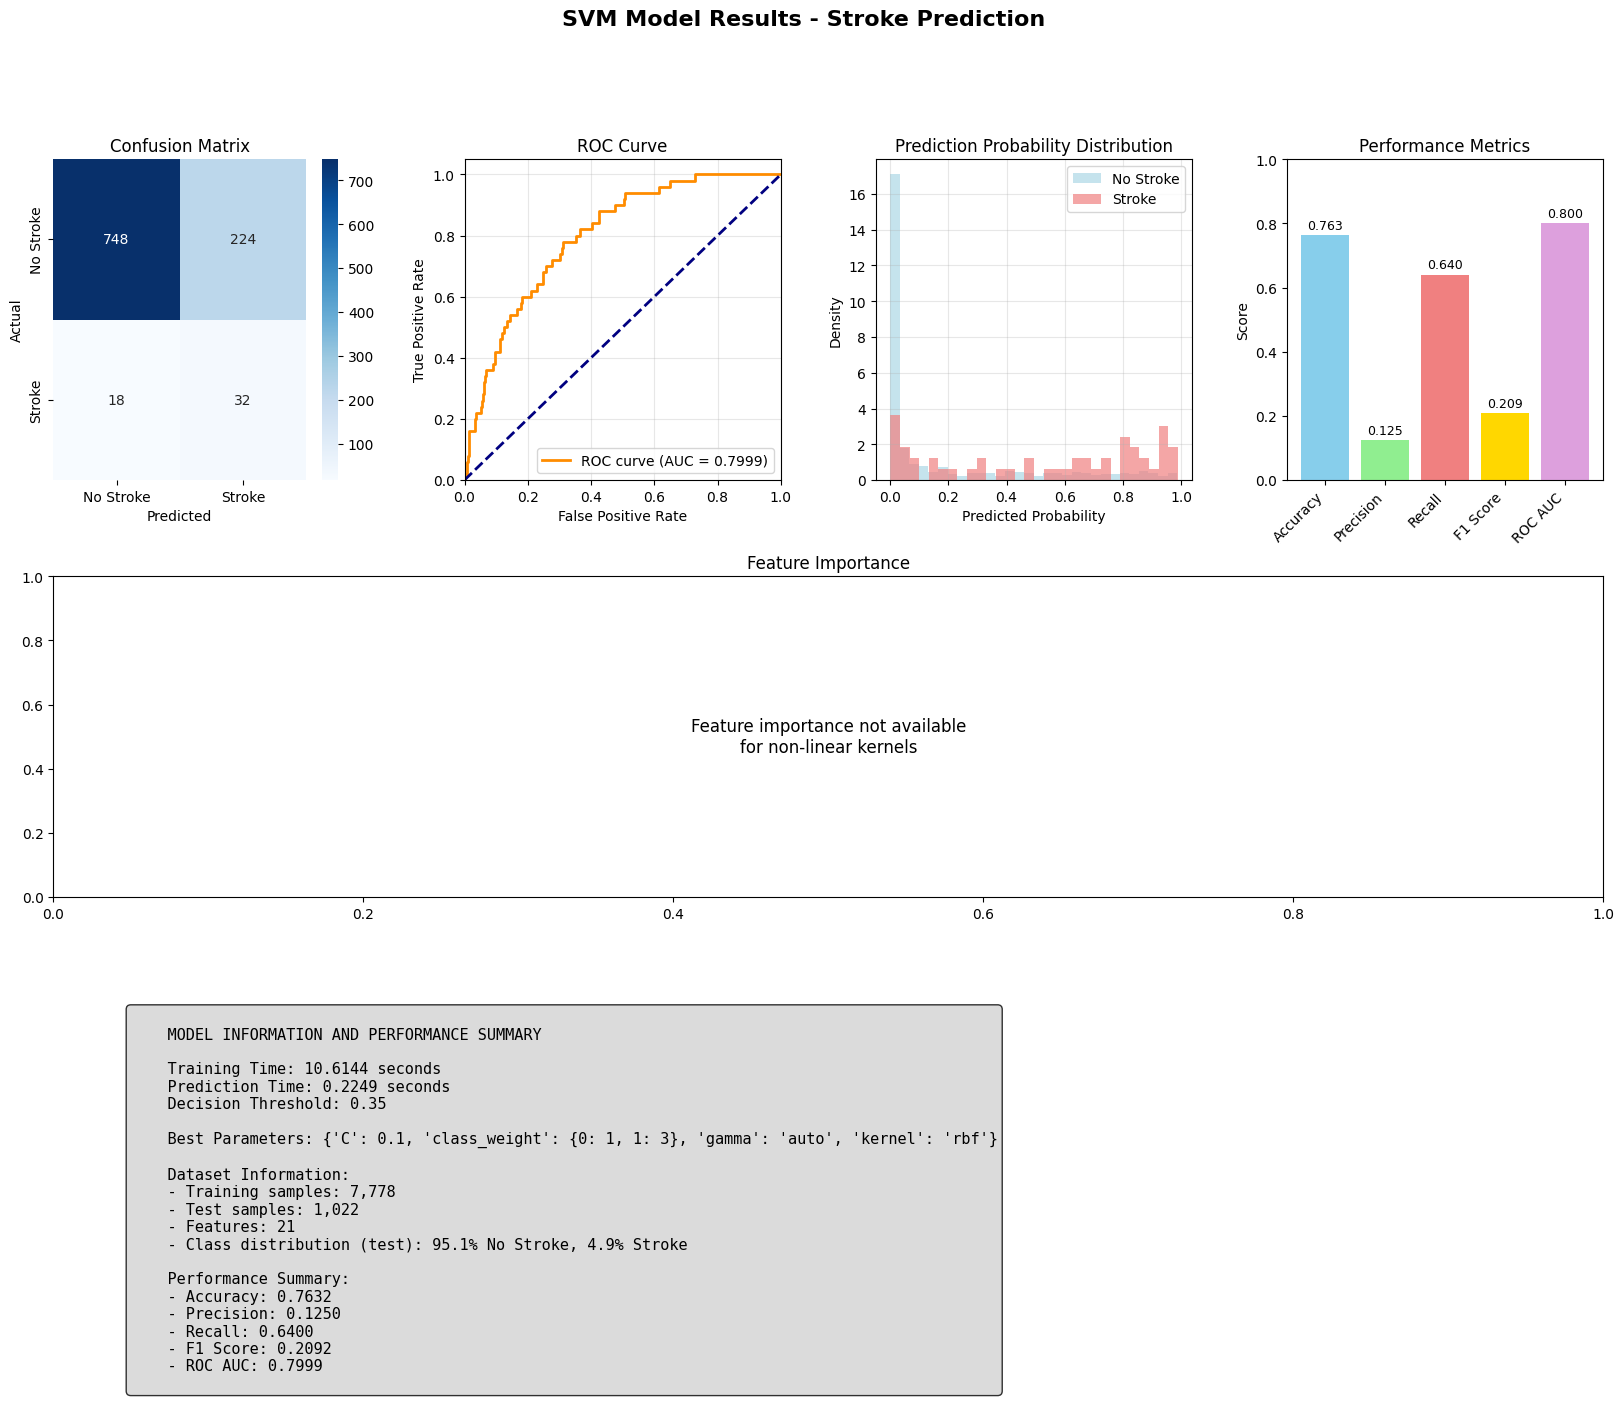

In [13]:
# Create comprehensive visualization
def plot_comprehensive_results(y_test, y_pred, y_pred_proba, metrics, feature_names, model):
    """Create comprehensive visualization of model results."""
    fig = plt.figure(figsize=(20, 15))
    
    # Create a grid layout
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # 3. Prediction Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
             label='No Stroke', color='lightblue', density=True)
    ax3.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
             label='Stroke', color='lightcoral', density=True)
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Prediction Probability Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance Metrics Bar Chart
    ax4 = fig.add_subplot(gs[0, 3])
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    metric_values = [
        metrics['accuracy'], metrics['precision'], 
        metrics['recall'], metrics['f1_score'], metrics['roc_auc']
    ]
    bars = ax4.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
    ax4.set_ylim(0, 1)
    ax4.set_title('Performance Metrics')
    ax4.set_ylabel('Score')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 5. Feature Importance (if available)
    ax5 = fig.add_subplot(gs[1, :])
    if hasattr(model, 'coef_') and model.coef_ is not None:
        try:
            feature_importance = np.abs(model.coef_[0])
            if hasattr(feature_importance, 'get'):
                feature_importance = feature_importance.get()
            
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=True).tail(15)
            
            bars = ax5.barh(feature_df['feature'], feature_df['importance'], color='steelblue')
            ax5.set_xlabel('Absolute Coefficient Value')
            ax5.set_title('Top 15 Feature Importance (Linear SVM Coefficients)')
            ax5.grid(True, alpha=0.3)
            
            for bar, value in zip(bars, feature_df['importance']):
                ax5.text(bar.get_width() + max(feature_df['importance'])*0.01, 
                        bar.get_y() + bar.get_height()/2,
                        f'{value:.3f}', ha='left', va='center', fontsize=8)
        except Exception as e:
            ax5.text(0.5, 0.5, f'Feature importance not available\nfor this kernel type\n({str(e)})', 
                    ha='center', va='center', transform=ax5.transAxes, fontsize=12)
            ax5.set_title('Feature Importance')
    else:
        ax5.text(0.5, 0.5, 'Feature importance not available\nfor non-linear kernels', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('Feature Importance')
    
    # 6. Model Information
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    info_text = f"""
    MODEL INFORMATION AND PERFORMANCE SUMMARY
    
    Training Time: {metrics.get('training_time', 0):.4f} seconds
    Prediction Time: {metrics.get('prediction_time', 0):.4f} seconds
    Decision Threshold: {metrics.get('threshold', 0.5):.2f}
    
    Best Parameters: {getattr(svm_model, 'best_params', 'Default parameters used')}
    
    Dataset Information:
    - Training samples: {len(X_train):,}
    - Test samples: {len(X_test):,}
    - Features: {len(feature_names)}
    - Class distribution (test): {(1-y_test.mean())*100:.1f}% No Stroke, {y_test.mean()*100:.1f}% Stroke
    
    Performance Summary:
    - Accuracy: {metrics['accuracy']:.4f}
    - Precision: {metrics['precision']:.4f}
    - Recall: {metrics['recall']:.4f}
    - F1 Score: {metrics['f1_score']:.4f}
    - ROC AUC: {metrics['roc_auc']:.4f}
    """
    
    ax6.text(0.05, 0.95, info_text, transform=ax6.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle('SVM Model Results - Stroke Prediction', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('svm_comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create the comprehensive visualization
plot_comprehensive_results(y_test, y_pred, y_pred_proba, metrics, feature_names, svm_model.model)

In [14]:
# Save the trained model
def save_svm_model(model, filepath='svm_stroke_model.joblib'):
    """Persist the CPU-based SVM model and related artifacts."""
    try:
        model_data = {
            'model': model.model,
            'scaler': model.scaler,
            'best_params': model.best_params,
            'training_time': model.training_time,
            'prediction_time': model.prediction_time,
            'feature_names': feature_names,
            'decision_threshold': model.decision_threshold
        }
        
        joblib.dump(model_data, filepath)
        print(f"Model saved successfully to {filepath}")
        print(f"Model size: {os.path.getsize(filepath) / (1024*1024):.2f} MB")
        
    except Exception as e:
        print(f"Error saving model: {e}")

# Save the model
import os
save_svm_model(svm_model)

Model saved successfully to svm_stroke_model.joblib
Model size: 0.61 MB


In [15]:
# Example of making predictions on new data
def predict_stroke_risk(model, scaler, new_data, feature_names, threshold=0.5):
    """
    Make stroke risk predictions on new data
    
    Args:
        model: Trained SVM model
        scaler: Fitted StandardScaler
        new_data: New data for prediction (DataFrame or array)
        feature_names: List of feature names
        threshold: Probability threshold for positive class
        
    Returns:
        tuple: (predictions, probabilities)
    """
    # Ensure data is in correct format
    if isinstance(new_data, pd.DataFrame):
        new_data = new_data[feature_names].values
    
    # Scale the data
    new_data_scaled = scaler.transform(new_data)
    
    # Compute probabilities and apply threshold for predictions
    probabilities = model.predict_proba(new_data_scaled)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    
    # Convert to numpy arrays if backend returns device arrays
    if hasattr(predictions, 'get'):
        predictions = predictions.get()
    if hasattr(probabilities, 'get'):
        probabilities = probabilities.get()
    
    return predictions, probabilities

# Example prediction on a few test samples
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)
print(f"Decision threshold for predictions: {svm_model.decision_threshold:.2f}")

# Take first 5 test samples
sample_data = X_test.iloc[:5]
sample_labels = y_test.iloc[:5]

predictions, probabilities = predict_stroke_risk(
    svm_model.model, svm_model.scaler, sample_data, feature_names,
    threshold=svm_model.decision_threshold
)

print("Sample Predictions:")
for i in range(len(predictions)):
    actual = "Stroke" if sample_labels.iloc[i] == 1 else "No Stroke"
    predicted = "Stroke" if predictions[i] == 1 else "No Stroke"
    probability = probabilities[i]
    
    print(f"Sample {i+1}:")
    print(f"  Actual: {actual}")
    print(f"  Predicted: {predicted}")
    print(f"  Stroke Probability: {probability:.4f}")
    print(f"  Correct: {'✓' if actual == predicted else '✗'}")
    print()


EXAMPLE PREDICTIONS
Decision threshold for predictions: 0.35
Sample Predictions:
Sample 1:
  Actual: No Stroke
  Predicted: No Stroke
  Stroke Probability: 0.0732
  Correct: ✓

Sample 2:
  Actual: No Stroke
  Predicted: No Stroke
  Stroke Probability: 0.0971
  Correct: ✓

Sample 3:
  Actual: No Stroke
  Predicted: No Stroke
  Stroke Probability: 0.0003
  Correct: ✓

Sample 4:
  Actual: No Stroke
  Predicted: No Stroke
  Stroke Probability: 0.0003
  Correct: ✓

Sample 5:
  Actual: No Stroke
  Predicted: Stroke
  Stroke Probability: 0.8566
  Correct: ✗



In [16]:
# Final summary
print("\n" + "="*70)
print("SVM MODEL - FINAL SUMMARY")
print("="*70)

print(f"\n🚀 PERFORMANCE SUMMARY:")
print(f"   • Training Time: {metrics['training_time']:.4f} seconds")
print(f"   • Prediction Time: {metrics['prediction_time']:.4f} seconds")
print(f"   • Decision Threshold: {metrics['threshold']:.2f}")
print(f"   • Model Accuracy: {metrics['accuracy']:.4f}")
print(f"   • F1 Score: {metrics['f1_score']:.4f}")
print(f"   • ROC AUC: {metrics['roc_auc']:.4f}")

print(f"\n📊 DATASET INFORMATION:")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Features: {len(feature_names)}")
print(f"   • Class Balance: {(1-y_test.mean())*100:.1f}% No Stroke, {y_test.mean()*100:.1f}% Stroke")

print(f"\n🔧 MODEL CONFIGURATION:")
print(f"   • Best Parameters: {svm_model.best_params}")
print(f"   • Hyperparameter Tuning: {'Quick Search' if QUICK_SEARCH else 'Comprehensive Search'}")
print(f"   • Grid Search Scoring Metric: {svm_model.scoring_metric}")
print(f"   • Cross-Validation: 3-fold")

print(f"\n💾 OUTPUT FILES:")
print(f"   • Model: svm_stroke_model.joblib")
print(f"   • Visualization: svm_comprehensive_results.png")

print(f"\n✅ RECOMMENDATIONS:")
if metrics['f1_score'] > 0.7:
    print(f"   • Model shows good performance for stroke prediction")
elif metrics['f1_score'] > 0.5:
    print(f"   • Model shows moderate performance - consider feature engineering")
else:
    print(f"   • Model needs improvement - try different algorithms or more data")

print(f"\n" + "="*70)
print("ANALYSIS COMPLETE - SVM MODEL READY FOR DEPLOYMENT")
print("="*70)


SVM MODEL - FINAL SUMMARY

🚀 PERFORMANCE SUMMARY:
   • Training Time: 10.6144 seconds
   • Prediction Time: 0.2249 seconds
   • Decision Threshold: 0.35
   • Model Accuracy: 0.7632
   • F1 Score: 0.2092
   • ROC AUC: 0.7999

📊 DATASET INFORMATION:
   • Training Samples: 7,778
   • Test Samples: 1,022
   • Features: 21
   • Class Balance: 95.1% No Stroke, 4.9% Stroke

🔧 MODEL CONFIGURATION:
   • Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'gamma': 'auto', 'kernel': 'rbf'}
   • Hyperparameter Tuning: Quick Search
   • Grid Search Scoring Metric: recall
   • Cross-Validation: 3-fold

💾 OUTPUT FILES:
   • Model: svm_stroke_model.joblib
   • Visualization: svm_comprehensive_results.png

✅ RECOMMENDATIONS:
   • Model needs improvement - try different algorithms or more data

ANALYSIS COMPLETE - SVM MODEL READY FOR DEPLOYMENT


KNN